## Pulling Data for Alzheimer's GBD Cause Model

In order to make the GBD cause model, we need to specify several values. The figure is included here as a reference. 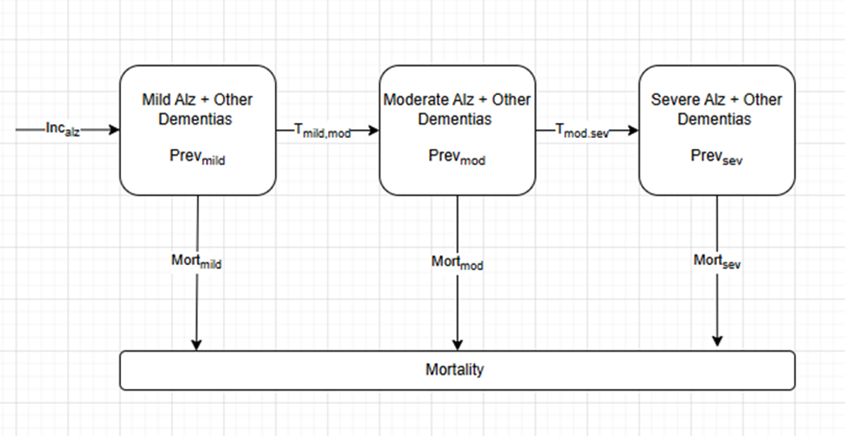

## Step 1: Load Packages and Data/Function

In [1]:
from db_queries import get_ids, get_population
from get_draws.api import get_draws
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import numpy as np

In [2]:
def get_gbd_values(age_id, sex_id, location_id):
    """
    Pulls GBD data for Alzheimer's disease and other dementias.
    """
    prevalence = get_draws(
        gbd_id_type=["sequela_id", "sequela_id", "sequela_id"],
        gbd_id=[452, 453, 454],  # mild, moderate, severe
        location_id=location_id,
        year_id=2021,
        source="como",
        release_id=9,
        measure_id=5,
        metric_id=3,
        age_group_id=age_id,
        sex_id=sex_id,
    )
    prevalence = get_draws(
        gbd_id_type=["sequela_id", "sequela_id", "sequela_id"],
        gbd_id=[452, 453, 454],  # mild, moderate, severe
        location_id=location_id,
        year_id=2021,
        source="como",
        release_id=9,
        measure_id=5,
        metric_id=3,
        age_group_id=age_id,
        sex_id=sex_id,
    )
    prevalence_all_alz = get_draws(
        gbd_id_type=["cause_id"],
        gbd_id=[543], #Alzheimer's disease and other dementias
        location_id=location_id,
        year_id=2021,
        source="como",
        release_id=9,
        measure_id=5,
        metric_id=3,
        age_group_id=age_id,
        sex_id=sex_id,
    )
    incidence = get_draws(
        gbd_id_type="cause_id",
        gbd_id=543, # Alzheimer's disease and other dementias
        location_id=location_id,
        year_id=2021,
        source="como",
        release_id=9,
        measure_id=6,
        metric_id=3,
        age_group_id=age_id,
        sex_id=sex_id,
    )
    deaths = get_draws(
        gbd_id_type="cause_id",
        gbd_id=[543,294], # Alzheimer's disease and other dementias and All cause
        location_id=location_id,
        year_id=2021,
        source="codcorrect",
        release_id=9,
        measure_id=1,
    #    metric_id=3,
        age_group_id=age_id,
        sex_id=sex_id,
    )
    population = get_population(
        release_id=9,
        age_group_id=age_id,
        location_id=location_id,
        year_id=2021,
        sex_id=sex_id,)
    return( 
        prevalence,
        prevalence_all_alz,
        incidence,
        deaths,
        population
    )

In [3]:
def process_gbd_for_means(dataframe,metric_name):
    draw_columns = dataframe.columns.str.startswith('draw_')
    draws = dataframe.loc[:, draw_columns]
    dataframe = dataframe.drop(draws, axis=1)
    dataframe[metric_name] = draws.mean(axis=1)
    return dataframe

In [4]:
def reformat_gbd_data(prevalence, prevalence_all_alz, incidence, deaths, population):
    mean_prev = process_gbd_for_means(prevalence, 'prev')
    mean_inc = process_gbd_for_means(incidence, 'inc')
    mean_deaths = process_gbd_for_means(deaths, 'deaths')
    mean_prev_all_alz = process_gbd_for_means(prevalence_all_alz, 'prev')
    alz_deaths = mean_deaths[mean_deaths['cause_id'] == 543].reset_index()
    acmr_deaths = mean_deaths[mean_deaths['cause_id'] == 294].reset_index()

    alz_prev = mean_prev_all_alz['prev'].iloc[0]
    acmr = (acmr_deaths['deaths'] / population['population']).iloc[0] 
    csmr = (alz_deaths['deaths'] / population['population']).iloc[0] 
    emr = (alz_deaths['deaths'] / (population['population'] * alz_prev)).iloc[0]

    prev_mild = mean_prev.loc[mean_prev.sequela_id == 452]['prev'].reset_index(drop=True).iloc[0]
    prev_mod = mean_prev.loc[mean_prev.sequela_id == 453]['prev'].reset_index(drop=True).iloc[0]
    prev_sev = mean_prev.loc[mean_prev.sequela_id == 454]['prev'].reset_index(drop=True).iloc[0]

    mean_inc = mean_inc['inc'].iloc[0]
    return(
        alz_prev,
        acmr,
        csmr,
        emr,
        prev_mild,
        prev_mod,
        prev_sev,
        mean_inc
    )

In [5]:
def data_from_literature(trans_prob_mild_to_mod, trans_prob_mod_to_sev, prob_mort_mild, prob_mort_mod, prob_mort_sev, prev_mild, prev_mod, prev_sev):
    trans_mild_mod = prev_mild * trans_prob_mild_to_mod
    trans_mod_sev = prev_mod * trans_prob_mod_to_sev 
    mort_mild = prev_mild * prob_mort_mild
    mort_mod = prev_mod * prob_mort_mod
    mort_sev = prev_sev * prob_mort_sev
    return(trans_mild_mod, trans_mod_sev, mort_mild, mort_mod, mort_sev)

## Step 2: Pick input values

In [6]:
# All ages, all sexes, United States
age_id = 22
sex_id = 3
location_id = 102 

In [7]:
# https://link.springer.com/article/10.1007/s40120-021-00272-1 
# Annual transition probabilities of mild to mod 31.6% and mod to severe 28.6% 
# Need to convert the annual transition probabilities to rates using the prevalence 
trans_prob_mild_to_mod = 0.316
trans_prob_mod_to_sev = 0.286

prob_mort_mild = 0.092
prob_mort_mod = 0.312
prob_mort_sev = 0.467

## Step 3: Solve the optimization

In [ ]:
## Optimization is giving a lot of zero values... Need to fix that. I'm not sure what is wrong currently 

In [25]:
def full_optimization(age_id, sex_id, location_id, trans_prob_mild_to_mod, trans_prob_mod_to_sev, prob_mort_mild, prob_mort_mod, prob_mort_sev):
    prevalence, prevalence_all_alz, incidence, deaths, population = get_gbd_values(age_id, sex_id, location_id)
    alz_prev, acmr, csmr, emr, prev_mild, prev_mod, prev_sev, mean_inc = reformat_gbd_data(prevalence, prevalence_all_alz, incidence, deaths, population)
    trans_mild_mod, trans_mod_sev, mort_mild, mort_mod, mort_sev = data_from_literature(trans_prob_mild_to_mod, trans_prob_mod_to_sev, prob_mort_mild, prob_mort_mod, prob_mort_sev, prev_mild, prev_mod, prev_sev)

    def error_function(params):
        mort_mild, mort_mod, mort_sev, csmr_mild, csmr_mod, csmr_sev, emr_mild, emr_mod, emr_sev, trans_mild_mod, trans_mod_sev = params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10]
        error_1 = abs(mort_sev - trans_mod_sev)
        error_2 = abs(mort_mod + trans_mod_sev - trans_mild_mod)
        error_3 = abs(mort_mild + trans_mild_mod - mean_inc)
        error_4 = abs(mort_mild - (acmr - csmr_mild + emr_mild))
        error_5 = abs(mort_mod - (acmr - csmr_mod + emr_mod))
        error_6 = abs(mort_sev - (acmr - csmr_sev + emr_sev))
        error_7 = abs(csmr - (csmr_mild + csmr_mod + csmr_sev))
        error_8 = abs(emr - (
        (emr_mild * (prev_mild / alz_prev))
        + (emr_mod * (prev_mod / alz_prev))
        + (emr_sev * (prev_sev / alz_prev))
    ))
        return error_1 + error_2 + error_3 + error_4 + error_5 + error_6 + error_7 + error_8

    initial_guess = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    bounds = [
        (0, None),  # mort_mild
        (0, None),  # mort_mod
        (0, None),  # mort_sev
        (0, None),  # csmr_mild
        (0, None),  # csmr_mod
        (0, None),  # csmr_sev
        (0, None),  # emr_mild
        (0, None),  # emr_mod
        (0, None),  # emr_sev
        (0, None),  # trans_mild_mod
        (0, None),  # trans_mod_sev
    ]

    res = minimize(error_function, initial_guess, bounds=bounds)

    def comparison_data(res):
        predicted_mort_mild = acmr - res.x[0] + res.x[3]
        predicted_mort_mod = acmr - res.x[1] + res.x[4]
        predicted_mort_sev = acmr - res.x[2] + res.x[5]
        predicted_trans_mild_mod = res.x[6]
        predicted_trans_mod_sev = res.x[7]
        comparison = [(predicted_mort_mild - mort_mild), (predicted_mort_mod - mort_mod), (predicted_mort_sev - mort_sev), (predicted_trans_mild_mod - trans_mild_mod), (predicted_trans_mod_sev - trans_mod_sev)]
        return comparison

    comparison = comparison_data(res)

    return(res, comparison)


In [26]:
results, comparison = full_optimization(age_id, sex_id, location_id, trans_prob_mild_to_mod, trans_prob_mod_to_sev, prob_mort_mild, prob_mort_mod, prob_mort_sev)

/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/get_draws/api.py:194: UserWarning: No version_id was specified, so get_draws will automatically determine a best version ID to use from the given parameters. If you want to retrieve a specific version please pass a version_id directly.
  warnings.warn(
/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: EPI_PASS_GET_RESULTS_TO_GET_ESTIMATES. The installed ihme_cc_rules_client package (version 4.0.2) is likely outdated and should be upgraded. If you see this warning in a central environment, please submit a Help Desk ticket for Central Comp: https://helpdesk.ihme.washington.edu
  warnings.warn(
/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: STGPR_PASS_GET_RESULTS_T

In [27]:
results

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.06884833220247932
        x: [ 3.860e-03  0.000e+00  0.000e+00  3.860e-03  3.860e-03
             3.860e-03  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
      nit: 1
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  5.367e-01  6.921e-01  7.712e-01  2.000e+00
             2.000e+00]
     nfev: 60
     njev: 5
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>

In [ ]:
# mort_mild, mort_mod, mort_sev, csmr_mild, csmr_mod, csmr_sev, emr_mild, emr_mod, emr_sev, trans_mild_mod, trans_mod_sev

In [28]:
comparison

[0.009810427417501176,
 0.012886756936641085,
 0.012728399337764224,
 -0.0021464462659270952,
 -0.0012907736397603337]

## Step 4: Scale up

In [99]:
## Make a loop to run the above function for different age/sex/location combinations
## Make a dataframe that stores the results and the input parameters used 
## Do some data seeking to adjust the literature input parameters 
## We should add a scale down factor to the GBD results to make it Alz only and not include other dementias